In [1]:
import cv2
import numpy as np
import os, random
from copy import deepcopy
import csv, json, boto3
import math
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN

import imutils
import numpy as np

from matplotlib import rcParams

# Main Functions

## Axes Detection

This code gives a best estimate of the x and y axis (horizontal and vertical axes) for the plot/chart.

### Method to detect x and y axis

In [20]:
def findMaxConsecutiveOnes(nums) -> int:
    count = maxCount = 0
    
    for i in range(len(nums)):
        if nums[i] == 1:
            count += 1
        else:
            maxCount = max(count, maxCount)
            count = 0
                
    return max(count, maxCount)

In [26]:
def detectAxes(filepath, threshold=None, debug=False):
    if filepath is None:
        return None, None
    
    if threshold is None:
        threshold = 10
    
    image = cv2.imread(filepath)
    height, width, channels = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.figure(figsize=(10, 5)) 
    plt.imshow(gray, 'gray') 
    plt.xticks([]),plt.yticks([])  
    plt.show()
    
    
    # Get the max-consecutive-ones for eah column in the bw image, and...
    # pick the "first" index that fall in [max - threshold, max + threshold]
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[:, idx] < 200) for idx in range(width)]
    
    start_idx, maxindex, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < width/2:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            start_idx += 1
            while abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
                maxindex = start_idx
                start_idx += 1
            break
            
        start_idx += 1
    
    yaxis = (maxindex, 0, maxindex, height)
    
    start_idx, y_right_index, maxcount = width-1, width-1, max(maxConsecutiveOnes)
    while start_idx > width/2:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            y_right_index = start_idx
            start_idx -= 1
            while abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
                y_right_index = start_idx
                start_idx -= 1
            break
            
        start_idx -= 1
           
    y_right_axis = (y_right_index, 0, y_right_index, height)
    
    if debug:
        plt.figure(figsize=(10, 5)) 
        plt.imshow(image, 'gray')
        plt.title('image')  
        plt.xticks([]),plt.yticks([])  
        plt.show()
        
        plt.figure(figsize=(10, 5)) 
        plt.plot(maxConsecutiveOnes, color = 'k')
        plt.axhline(y = max(maxConsecutiveOnes) - 10, color = 'r', linestyle = 'dashed')
        plt.axhline(y = max(maxConsecutiveOnes) + 10, color = 'r', linestyle = 'dashed')
        plt.vlines(x = maxindex, ymin = 0.0, ymax = maxConsecutiveOnes[maxindex], color = 'b', linewidth = 4)

        plt.show()

    # Get the max-consecutive-ones for eah row in the bw image, and...
    # pick the "last" index that fall in [max - threshold, max + threshold]
    maxConsecutiveOnes = [findMaxConsecutiveOnes(gray[idx, :] < 200) for idx in range(height)]
    start_idx, maxindex, maxcount = height-1, height-1, max(maxConsecutiveOnes)
    while start_idx > height/2:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            maxindex = start_idx
            start_idx -= 1
            while abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
                maxindex = start_idx
                start_idx -= 1
            break
            
        start_idx -= 1
            
    cv2.line(image, (0, maxindex), (width, maxindex),  (255, 0, 0), 2)
    xaxis = (0, maxindex, width, maxindex)
    
    start_idx, x_up_index, maxcount = 0, 0, max(maxConsecutiveOnes)
    while start_idx < height/2:
        if abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
            x_up_index = start_idx
            start_idx += 1
            while abs(maxConsecutiveOnes[start_idx] - maxcount) <= threshold:
                x_up_index = start_idx
                start_idx += 1
            break
            
        start_idx += 1
            
    x_up_axis = (0, x_up_index, width, x_up_index)
    
    if debug:
        rcParams['figure.figsize'] = 15, 8

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image, aspect = 'auto')
        
    return xaxis, yaxis, x_up_axis, y_right_axis

## Text Rekognition

In [4]:
'''
Code for this part from 
https://github.com/Cvrane/ChartReader/blob/master/code/AWS-Text-Rekognition.ipynb
'''

def expand(points, margin = 1):
    return np.array([
        [[points[0][0][0] - margin, points[0][0][1] - margin]],
        [[points[1][0][0] + margin, points[1][0][1] - margin]],
        [[points[2][0][0] + margin, points[2][0][1] + margin]],
        [[points[3][0][0] - margin, points[3][0][1] + margin]]])

def detectText(path, image, image_text, img_text):
    
    img_height, img_width, channels = image.shape
    _, im_buf = cv2.imencode("." + path.name.split(".")[-1], image)
        
    response = client.detect_text(
        Image = {
            "Bytes" : im_buf.tobytes()
        }
    )
    
    if path.name not in image_text:
        image_text[path.name] = {}
        image_text[path.name]['TextDetections'] = response['TextDetections']
    else:
        image_text[path.name]['TextDetections'].extend(response['TextDetections'])
        
    textDetections = response['TextDetections']
        
    if path.name not in img_text:
        img_text[path.name] = []
            
    for text in textDetections:
        if text['Type'] == 'WORD' and text['Confidence'] >= 80:
                
            vertices = [[vertex['X'] * img_width, vertex['Y'] * img_height] for vertex in text['Geometry']['Polygon']]
            vertices = np.array(vertices, np.int32)
            vertices = vertices.reshape((-1, 1, 2))
            
            image = cv2.fillPoly(image, [expand(vertices)], (255, 255, 255))
                  
            left = np.amin(vertices, axis=0)[0][0]
            top = np.amin(vertices, axis=0)[0][1]
            right = np.amax(vertices, axis=0)[0][0]
            bottom = np.amax(vertices, axis=0)[0][1]
            
            img_text[path.name].append(
                (
                    text['DetectedText'],
                    (
                        int(left),
                        int(top),
                        int(right - left),
                        int(bottom - top)
                    )
                )
            )

    return image

## Color Cluster

In [5]:
def color_cluster(img, name='', save_dir='', debug=False):
    
    line_imgs = []
    
    if debug == True:
        # display original image
        display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 5)) 
        plt.imshow(display, 'gray')
        plt.title('image before cluster')  
        plt.xticks([]),plt.yticks([])  
        plt.show()

    data = img.reshape((-1,3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS +
                cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    flags = cv2.KMEANS_RANDOM_CENTERS
    NUM_CLUSTERS = 16

    compactness, labels, centers = cv2.kmeans(data, NUM_CLUSTERS, None, criteria, 10, flags)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    
    # get the class with the most pixels (white background)
    clusters = np.zeros([16], dtype=np.int32)
    for i in range(len(labels)):
        clusters[labels[i]] += 1
    center_bg = np.argmax(clusters)
    
    # TODO: how to deal with the generated images
    if debug == True:
        plt.subplots(figsize=(30, 20)) 

    for i in range(len(centers)):
        line_labels = np.full_like(labels, center_bg)
        line_labels[labels==i] = i
        
        line_res = centers[line_labels.flatten()]
        line_img = line_res.reshape((img.shape))

        if name != '':
            image_save_dir = os.path.join(save_dir, '.'.join(name.split(".")[:-1])+'_'+str(i)+'.png')
#             image_save_dir = os.path.join(save_dir, name+'_'+str(i)+'.png')
            cv2.imwrite(image_save_dir, line_img)
        
        if debug == True:
            line_img = cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB)
            line_imgs.append(line_img)

            plt.subplot(4,4,i+1)
            plt.imshow(line_img, 'gray')
            plt.title(str(i+1))
#             plt.title(str(centers[i]))  
            plt.xticks([]),plt.yticks([])  

    if debug == True:
        plt.show()
    return line_imgs

# Data Extraction for one line

In [6]:

'''extract data for image with just one line'''
def data_of_one_line(img, name='', save_dir='', data_file='', debug=False):
    
    data_points = []
    
    if debug==True:
        plt.subplots(figsize=(15, 10)) 

        # display image
        display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,2,1)
        plt.imshow(display, 'gray')
        plt.title('original line image')  
        plt.xticks([]),plt.yticks([])  

    # use color cluster again to distinguish line and background
    data = img.reshape((-1,3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS +
                cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    NUM_CLUSTERS = 2
    compactness, labels, centers = cv2.kmeans(data, NUM_CLUSTERS, None, criteria, 10, flags)
    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    
    # get the class with the most pixels (white background)
    clusters = np.zeros([16], dtype=np.int32)
    for i in range(len(labels)):
        clusters[labels[i]] += 1
    center_bg = np.argmax(clusters)
    
    for i in range(len(centers)):
        line_labels = np.full_like(labels, center_bg)
        line_labels[labels==i] = i
        
        if i == center_bg: # disgard the background class
            continue
        
        img_h, img_w = img.shape[0],img.shape[1]
        labels_img = labels.reshape((img_h, img_w))
        
        data_pts = np.full((img_w, 2), -1)
        last_data_pt = [-1,-1]
        max_h_diff = 0
        for x in range(3, img_w): # ignore some margin in left
            ver_labels = labels_img[:,x].reshape(-1)
            if np.argwhere(ver_labels!=center_bg).shape[0] != 0:
                
                ver_line_pixels = np.argwhere(ver_labels!=center_bg).reshape(-1,1)
                
                # clustering on one vertical line to get the position of line data
                MAX_GAP=3
                clustering = DBSCAN(eps=MAX_GAP, min_samples=1).fit(ver_line_pixels)
                ver_centers = []
                ver_counts = []
                for c in np.unique(clustering.labels_):
                    pts = ver_line_pixels[np.argwhere(clustering.labels_==c)].reshape(-1)
                    ver_centers.append(np.mean(pts, dtype=np.int32))
                    ver_counts.append(len(pts))
                
                ver_centers = np.array(ver_centers)
                ver_counts = np.array(ver_counts)
                if ver_centers.size == 1:
                    if last_data_pt[0] != -1 and abs(ver_centers[0]-last_data_pt[1])>max_h_diff*2: 
                        data_h = -1
                    else:
                        data_h = ver_centers[0]
                elif last_data_pt[0] != -1:
                    nearest_id = (np.abs(ver_centers - last_data_pt[1])).argmin()
                    thickest_id = ver_counts.argmax()
                    if ver_counts[nearest_id] < 3 and ver_counts[thickest_id] >= 3:
                        data_h = ver_centers[thickest_id]
                    else:
                        data_h = ver_centers[nearest_id]
                else:
                    data_h = random.choice(ver_centers) 
                    
                if data_h != -1:
                    display = cv2.circle(img, (x, data_h), 1, (255,0,255), 2)
                    data_points.append((x, data_h))

                    data_pts[x] = [x, data_h]
                    max_h_diff = max(data_h - last_data_pt[1], max_h_diff)
                    last_data_pt = [x, data_h]
              
        if data_file != '':  
            data_to_save = np.full(((img_w-1)//10+1, 2), -1)
            for x in range(data_to_save.shape[0]):
                data_to_save[x] = [x*10, data_pts[x*10,1]]
                
            row_to_save = [name]
            row_to_save.append(data_to_save)
            with open(data_file,'a',newline='') as f:
                writer=csv.writer(f)
                writer.writerow(row_to_save)
            
        if name != '':
            image_save_dir = os.path.join(save_dir, name)
            cv2.imwrite(image_save_dir, display)
        
        if debug==True:
            display = cv2.cvtColor(display, cv2.COLOR_BGR2RGB)
            plt.subplot(1,2,2)
            plt.imshow(display, 'gray')
            plt.title('data points shown in dot')  
            plt.xticks([]),plt.yticks([])  
    if debug==True:
        plt.show()
    
    return data_points

# Integrated

## Pre processing

[0] file name: 1.jpg


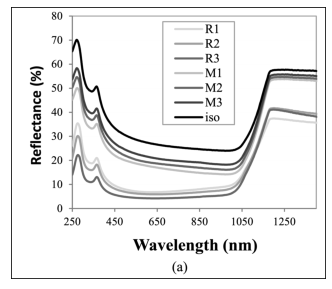

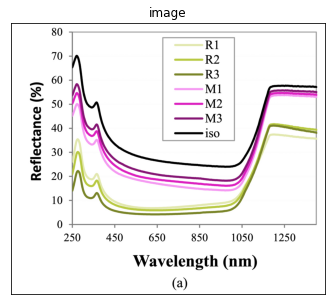

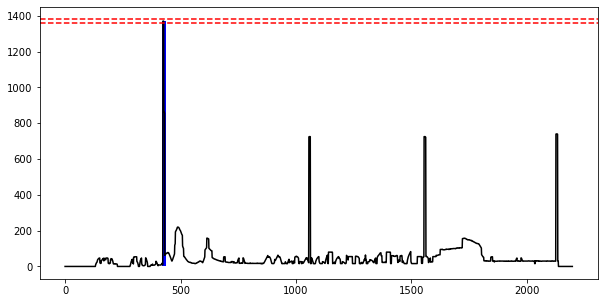

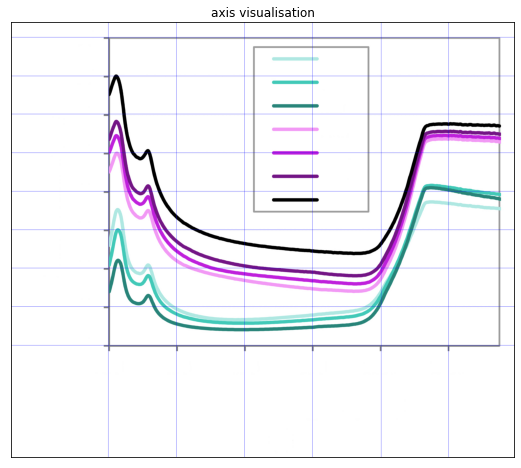

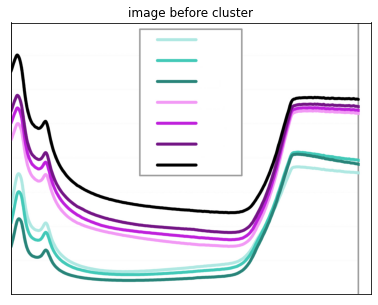

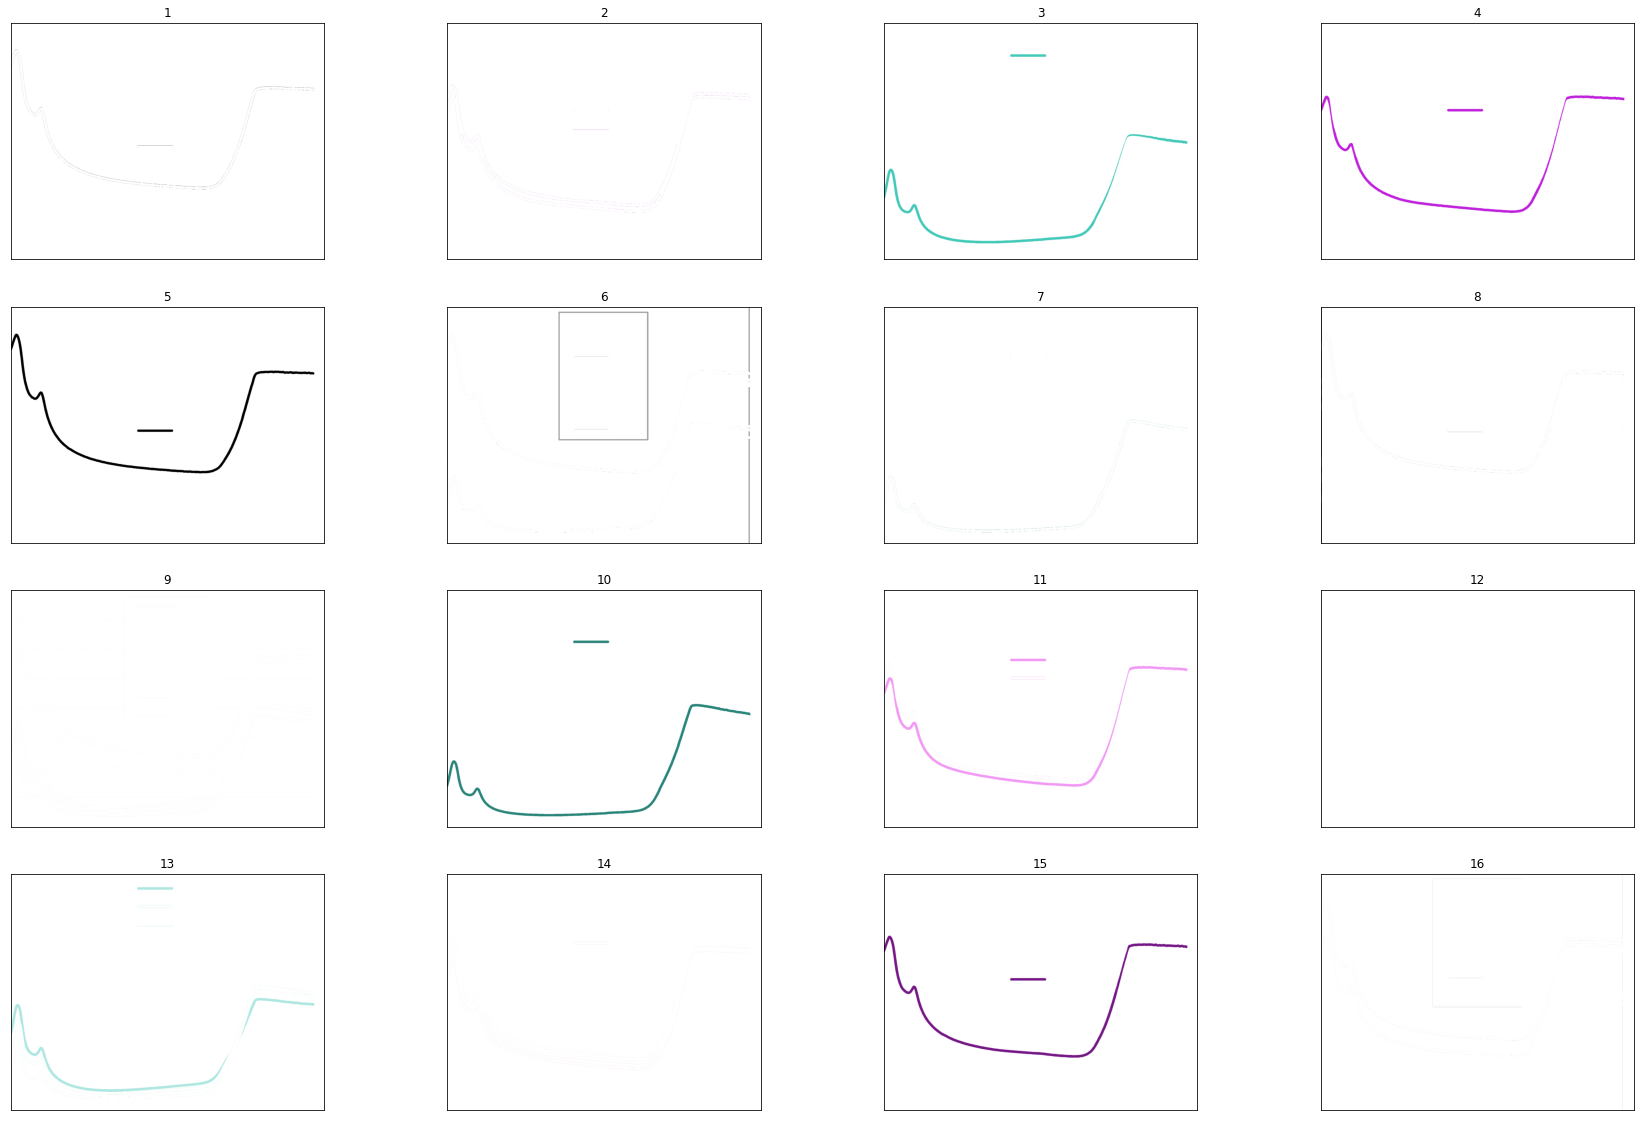

In [27]:
# 20220419

img_dir = './test/ori/'

cluster_img_save = False
if cluster_img_save:
    cluster_save_dir = './test/4-ColorCluster/'
    if not os.path.isdir(cluster_save_dir):
        os.mkdir(cluster_save_dir)


img_text = {}
image_text = {}
client = boto3.client('rekognition', region_name = 'us-west-2')

debug = True

for index, path in enumerate(Path(img_dir).iterdir()):
    if path.name.lower().endswith('.png') or path.name.lower().endswith('.jpg') or path.name.lower().endswith('.jpeg'):
        filepath = img_dir + "/" + path.name

        print("[{0}] file name: {1}".format(index, path.name))
        
        ##### Axis Detection #####
        xaxis, yaxis, x_up_axis, y_right_axis = detectAxes(filepath,debug=debug)

        xaxis_yvalue = xaxis[1]-1
        yaxis_xvalue = yaxis[0]+1
        up_yvalue = x_up_axis[1]+1
        right_xvalue = y_right_axis[0]-1


        ##### Text Rekognition #####
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = detectText(path, image, image_text, img_text)
        image = detectText(path, image, image_text, img_text)
        
        image_crop_del = image[x_up_axis[1]+1:xaxis[1], yaxis[0]+1:y_right_axis[0]]

        
        ##### X and Y Coords #####
        if debug:
            image_show = deepcopy(image)

        x_coords = []
        y_coords = []
        
        # judge if the detected text is int outside the axis
        for i in range(len(img_text[path.name])):
            if img_text[path.name][i][0].replace('.','',1).isdigit():
                if img_text[path.name][i][1][0] + img_text[path.name][i][1][2] < yaxis_xvalue:
        #             print(img_text[path.name][i][0], "y coords", img_text[path.name][i][1])

                    axis_text = img_text[path.name][i][0]
                    bbox = img_text[path.name][i][1]
                    y_mid = bbox[1] + bbox[3]/2
                    y_coords.append([float(axis_text), bbox, y_mid])

                    if debug:
                        y = int(img_text[path.name][i][1][1] + img_text[path.name][i][1][3]/2)
                        cv2.line(image_show, (0, y), (image_show.shape[1], y),  (0, 0, 255), 1)
                if img_text[path.name][i][1][1] > xaxis_yvalue:
        #             print(img_text[path.name][i][0], "x coords", img_text[path.name][i][1])

                    axis_text = img_text[path.name][i][0]
                    bbox = img_text[path.name][i][1]
                    x_mid = bbox[0] + bbox[2]/2
                    x_coords.append([int(axis_text), bbox, x_mid])

                    if debug:
                        x = int(bbox[0] + bbox[2]/2)
                        cv2.line(image_show, (x, 0), (x, image_show.shape[0]),  (0, 0, 255), 1)


        # display image
        if debug:
            plt.imshow(image_show, 'gray')
            plt.title('axis visualisation')  
            plt.xticks([]),plt.yticks([])  
            plt.show()

#             plt.imshow(image_crop_del, 'gray')
#             plt.title('image cropped and delete text')  
#             plt.xticks([]),plt.yticks([])  
#             plt.show()

        ##### Color Cluster #####
        image_crop_del = cv2.cvtColor(image_crop_del, cv2.COLOR_RGB2BGR)
        if cluster_img_save:
            line_imgs = color_cluster(image_crop_del, path.name, cluster_save_dir, debug=True)
        else:
            line_imgs = color_cluster(image_crop_del, debug=True)



## Manual Select 

In [8]:
# manual select
line_img_indices = []
while True:
    print("\nEnter one index (1-16) of the graph with line: (Press Enter with no input if there's no more line img)")
    index = input()
    if index == "":
        print("Indices: ", line_img_indices)
        break
    line_img_indices.append(int(index))


Enter one index (1-16) of the graph with line: (Press Enter with no input if there's no more line img)


KeyboardInterrupt: Interrupted by user

In [14]:
# all 16 images
line_img_indices = [i+1 for i in range(16)]


## Select by Completeness

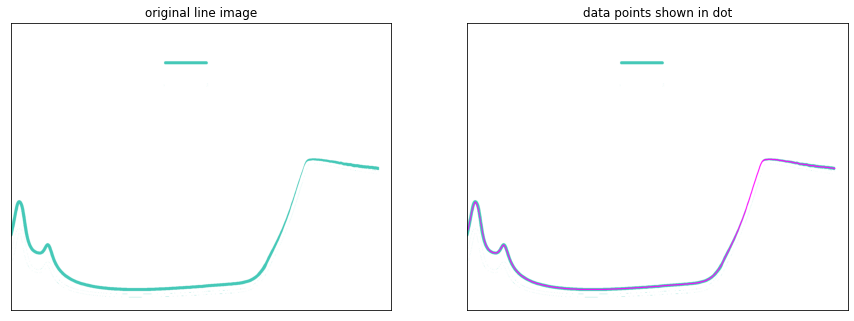

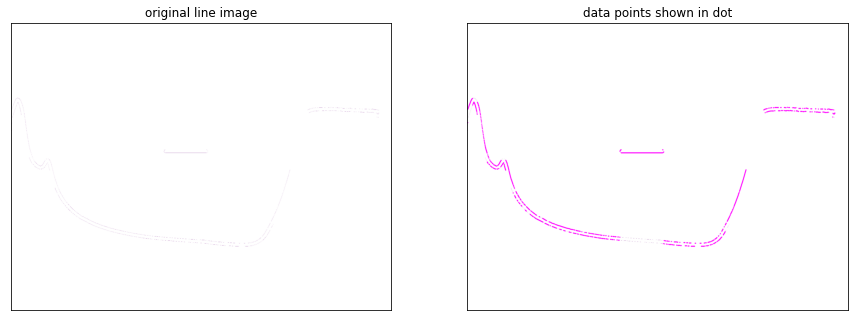

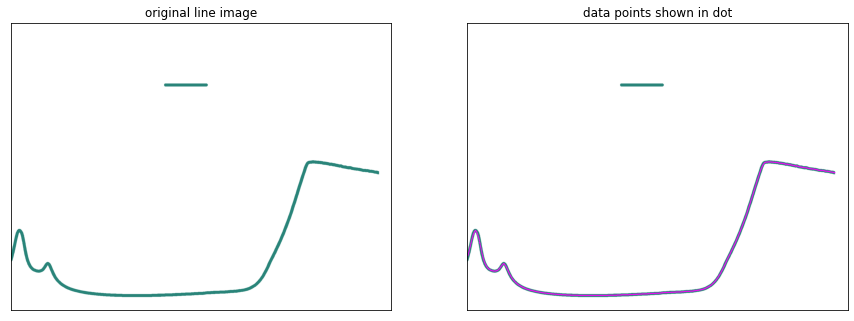

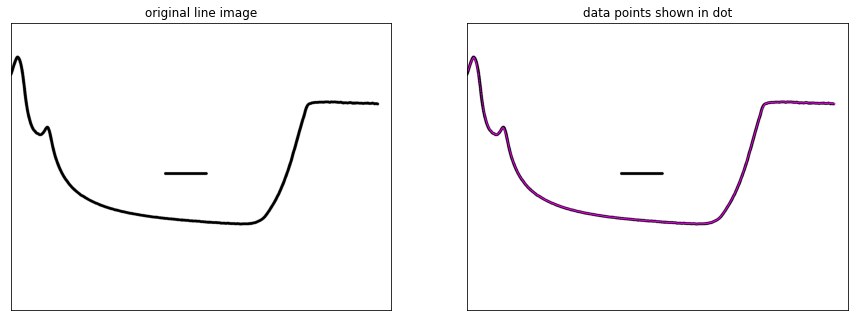

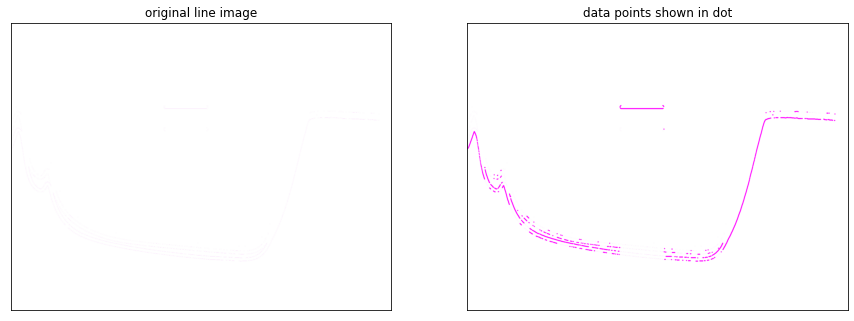

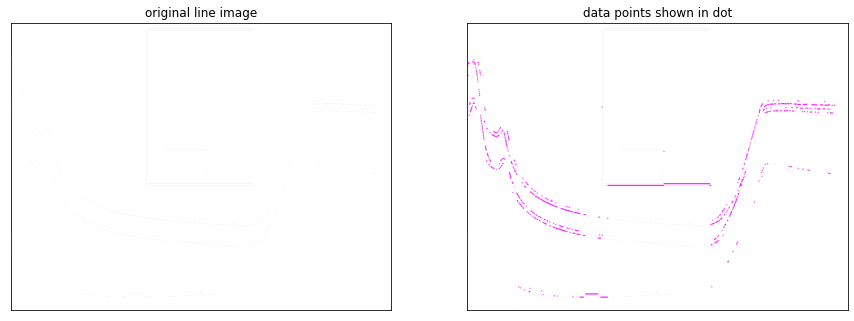

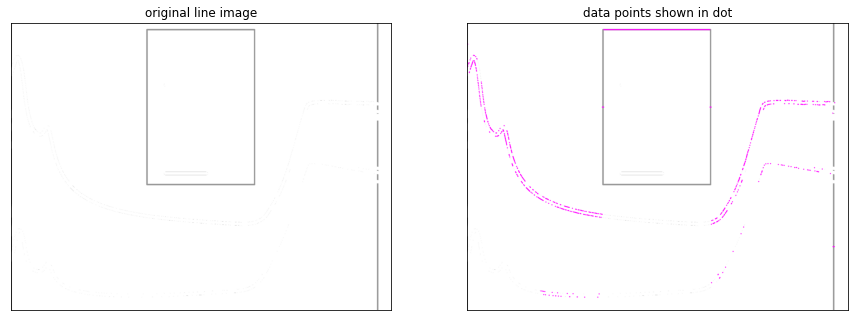

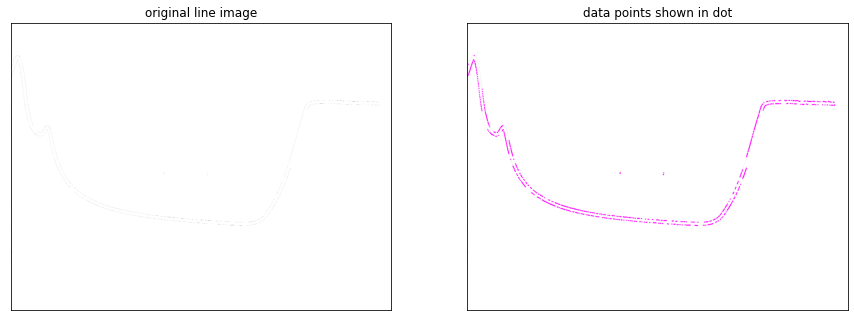

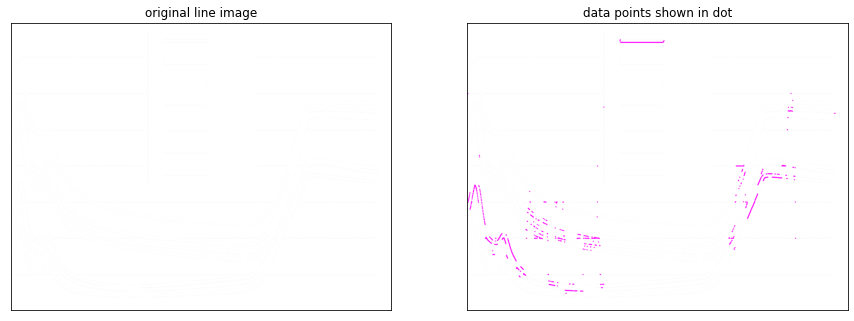

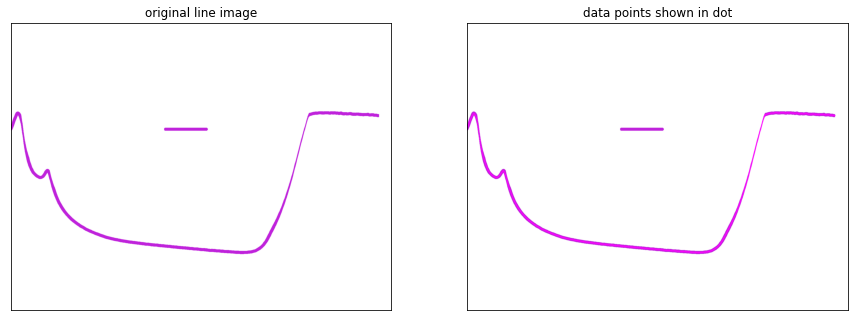

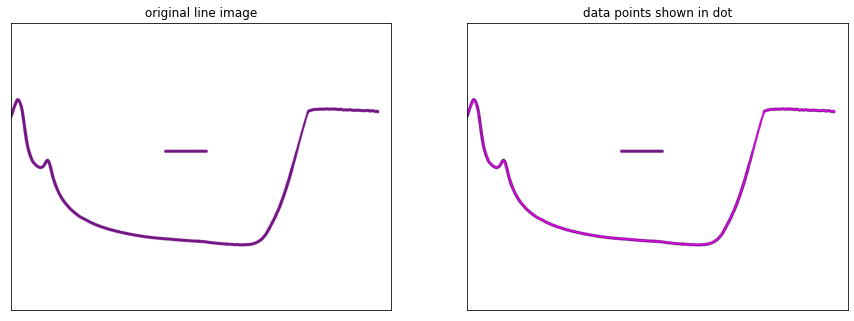

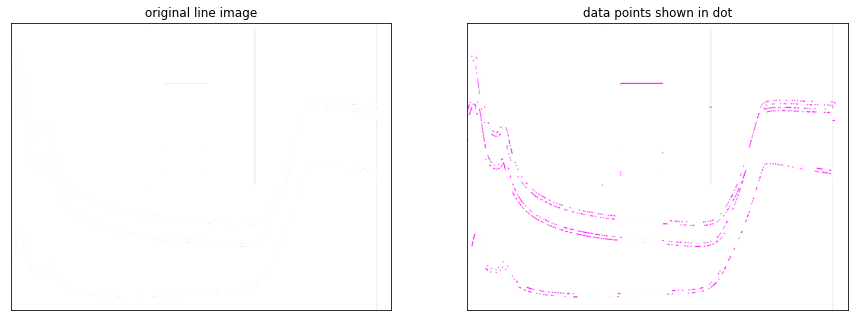

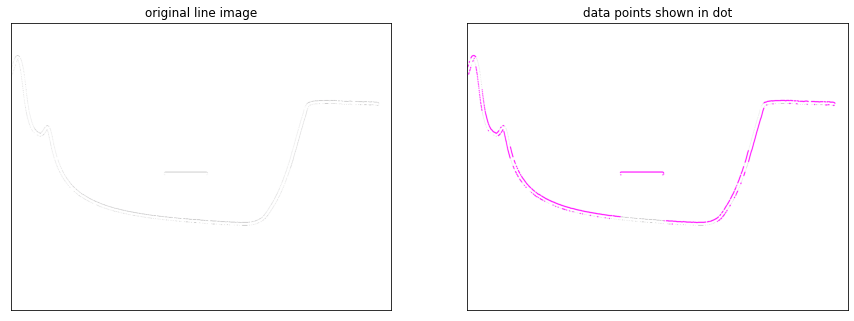

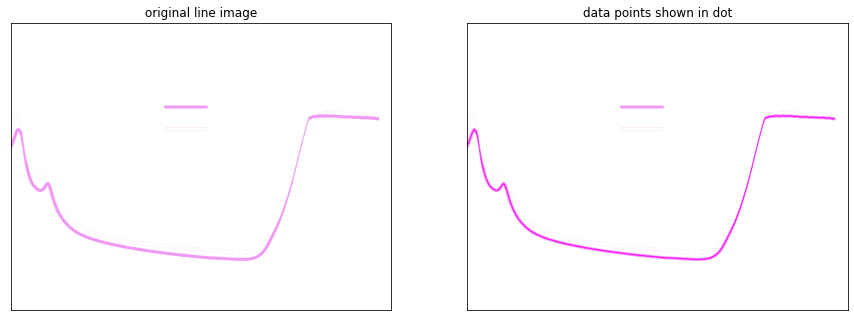

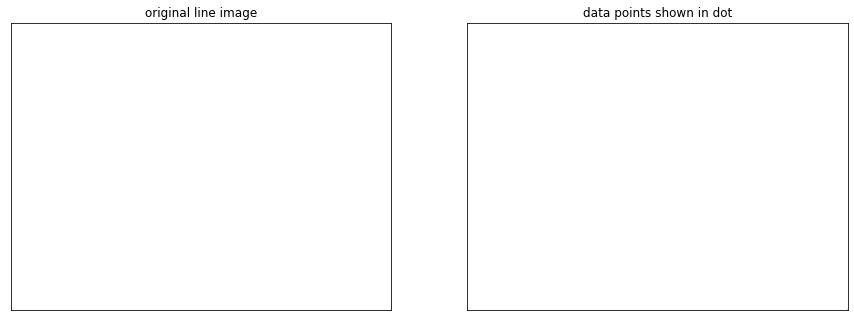

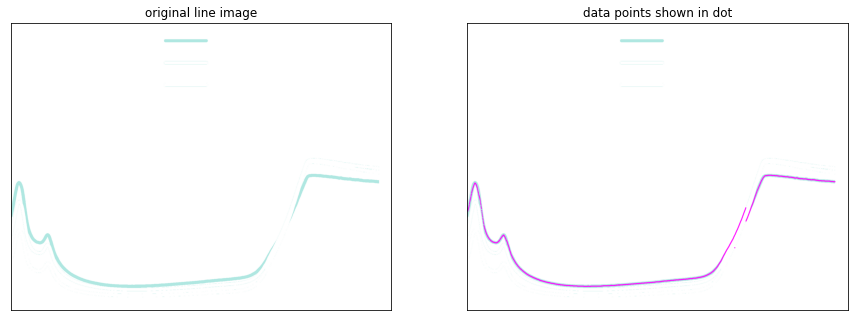

[1706, 1266, 1706, 1706, 1513, 1523, 1131, 1017, 1697, 1706, 1706, 1299, 1490, 1706, 1, 1706]


In [18]:
completeness = []
for line_img_i in line_img_indices:
    image = line_imgs[line_img_i-1]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    data_points = data_of_one_line(image, debug=True)
    num_of_points = len(data_points)
    completeness.append(num_of_points)

select_img_index = []
print(completeness)
for i in range(7):
    max_index = completeness.index(max(completeness))
    select_img_index.append(max_index)
    completeness[max_index] = -1

## Save data result

1769


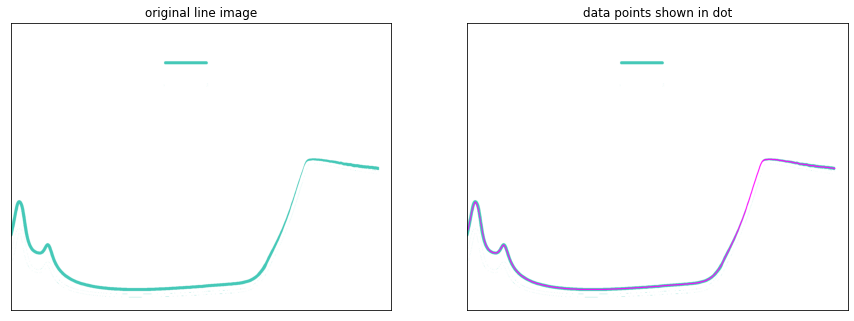

1706
1769


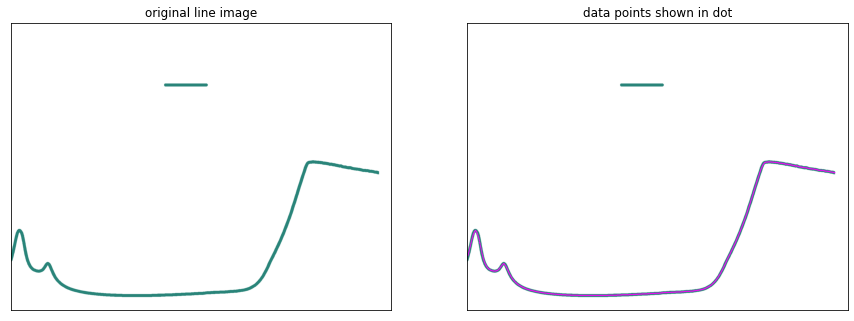

1706
1769


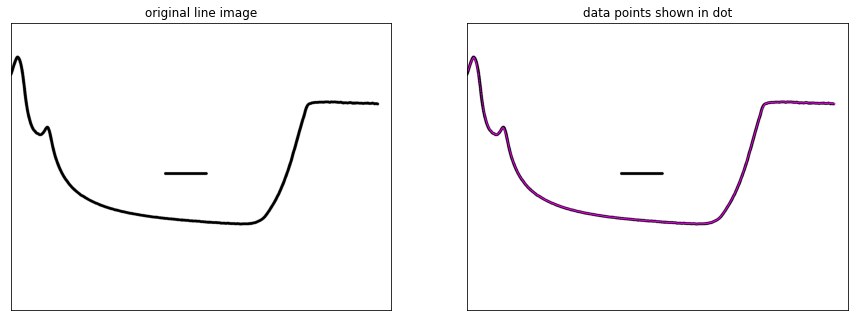

1706
1769


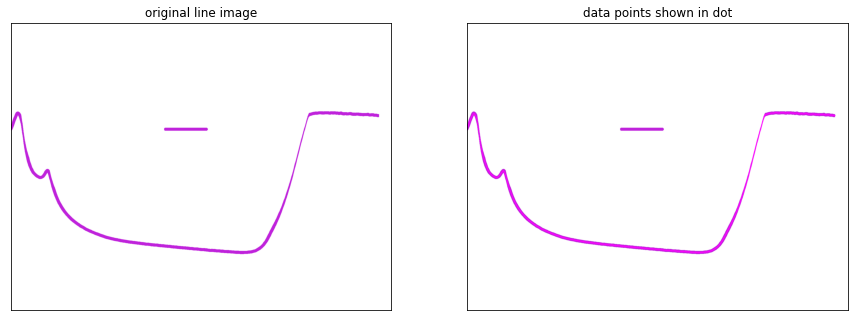

1706
1769


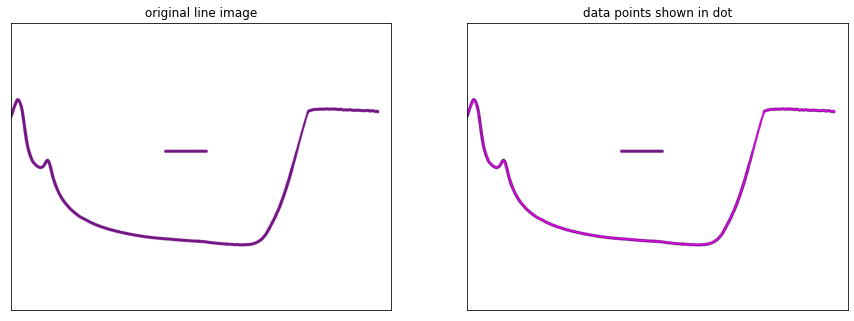

1706
1769


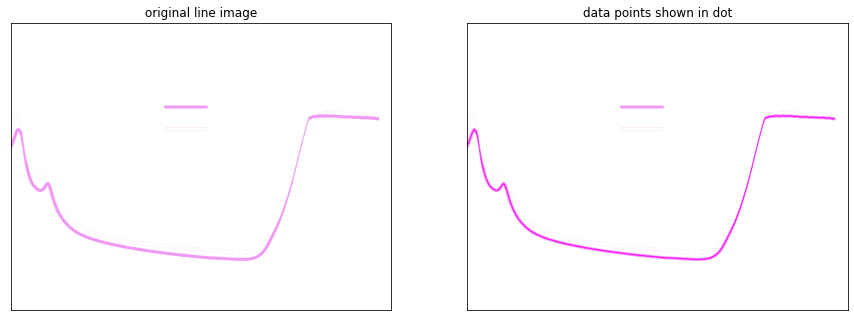

1706
1769


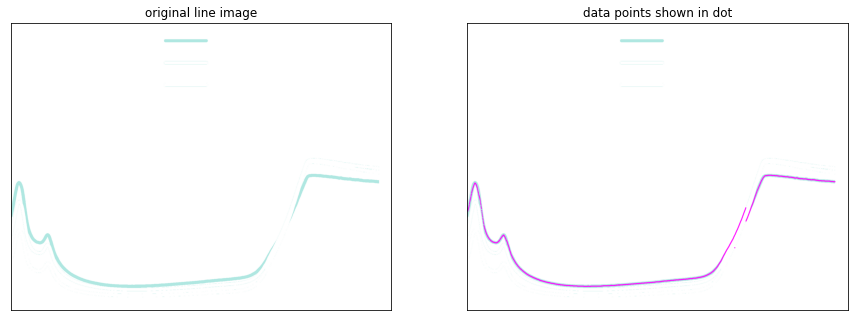

1706


In [19]:
'''data extraction on images with just one line'''

data_save_dir = "./test/DataResult/"
if not os.path.isdir(data_save_dir):
    os.mkdir(data_save_dir)

            
for line_img_i in select_img_index:

    image = line_imgs[line_img_i]
    print(image.shape[1])
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # data points in image pixels
    data_points = data_of_one_line(image, debug=True)
    print(len(data_points))

    # below: convert points in pixels to real line chart data
    data_points = np.array(data_points)
    data_points[:,0] += yaxis_xvalue
    data_points[:,1] += up_yvalue
    sort_index = np.lexsort((data_points[:,1], data_points[:,0])) # sort the data points according to x values
    data_points = data_points[sort_index,:]

    y_value_pixels = np.zeros((len(y_coords), 2))
    for i in range(len(y_coords)):
        y_value_pixels[i] = [y_coords[i][0], y_coords[i][2]]

    sort_index = np.lexsort((y_value_pixels[:,0], y_value_pixels[:,1])) # sort the data points according to x values
    y_value_pixels = y_value_pixels[sort_index,:]

    
    data_file = os.path.join(data_save_dir + str(line_img_i) + ".csv")
    assert(not os.path.isfile(data_file))

    with open(data_file,'w',newline='') as f:
        writer=csv.writer(f)
    #     header="img_name","x","y"
        header="x","y"
        writer.writerow(header)



        # x precision 1

        for i in range(len(x_coords)-1):
            interval_len = x_coords[i+1][0] - x_coords[i][0]
            interval_len_pixel_f = x_coords[i+1][2] - x_coords[i][2]

            x_results = [x for x in range(x_coords[i][0], x_coords[i+1][0])]
            x_pixel_floats = [x_coords[i][2] + interval_len_pixel_f / interval_len * (x-x_coords[i][0]) for x in range(x_coords[i][0], x_coords[i+1][0])]

            indices = np.searchsorted(data_points[:,0], x_pixel_floats)

            for xi in range(len(x_results)): 
                if x_pixel_floats[xi] > data_points[0,0] and x_pixel_floats[xi] < data_points[-1,0]:
                    if data_points[indices[xi],0] == x_pixel_floats[xi]:
                        y_pixel = data_points[indices[xi],1]
                    else:
                        y_pixel = ( (data_points[indices[xi],1] - data_points[indices[xi]-1,1]) / 
                                    (data_points[indices[xi],0] - data_points[indices[xi]-1,0]) * 
                                    (x_pixel_floats[xi] - data_points[indices[xi]-1,0]) ) + data_points[indices[xi]-1,1]

                    if y_pixel > min(y_value_pixels[:,1]) and y_pixel < max(y_value_pixels[:,1]):
                        y_insert_index = np.searchsorted(y_value_pixels[:,1], y_pixel)

                        y_result = ((y_value_pixels[y_insert_index,0] - y_value_pixels[y_insert_index-1,0]) / 
                                    (y_value_pixels[y_insert_index,1] - y_value_pixels[y_insert_index-1,1]) * 
                                    (y_pixel - y_value_pixels[y_insert_index-1,1])) + y_value_pixels[y_insert_index-1,0]

                        xy_result = [x_results[xi], y_result]
                        writer.writerow(xy_result)
    